# Kmeans

Kmeans is an algorithm unsupervised clustering, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid). The centroid thus serves as a prototype of its cluster.

## 0. The K-mean algorithm

Given $n$ points in an $m$-dimensional space, and a number of clusters $k$, 
the k-mean algorithm starts with an initilization step where initial cluster centroids are positionned.

> note : a centroid corresponds to a point is space that is the geomatric center of other points. It is, in a sense, a *mean* of the cluster, hence the name of the algorithm.

Here, our **initialization step** consists in assigning a random category to each point, and then computing the initial centroids from this assignment (NB: there exists other methods).

After this, the algorithm consists of 2 steps:
 * **Point assignment** : each point is assigned to the cluster with the nearest centroid.
 * **Centroid update** : each centroid is re-computed from the assigned points

These two steps are repeated until convergence, typically until no point changes assignment from one iteration to the other.

Here is a graphical overview of the algorithm:

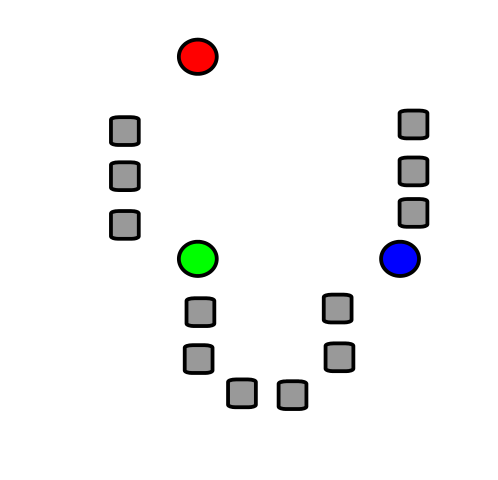

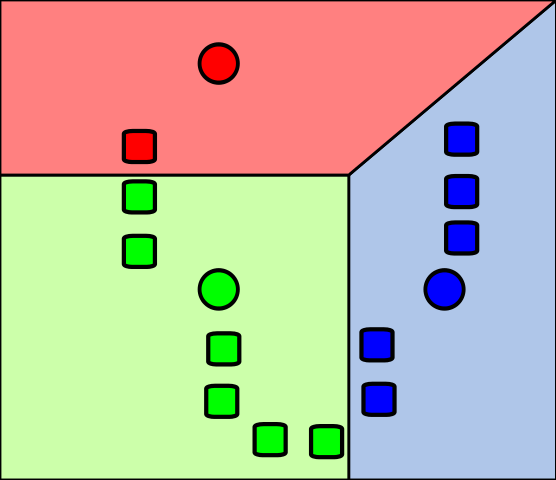

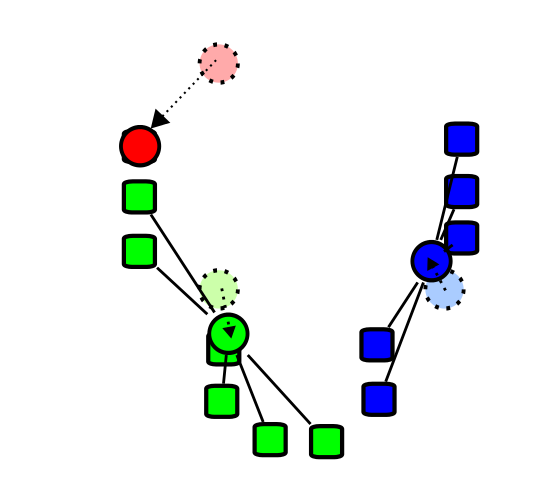

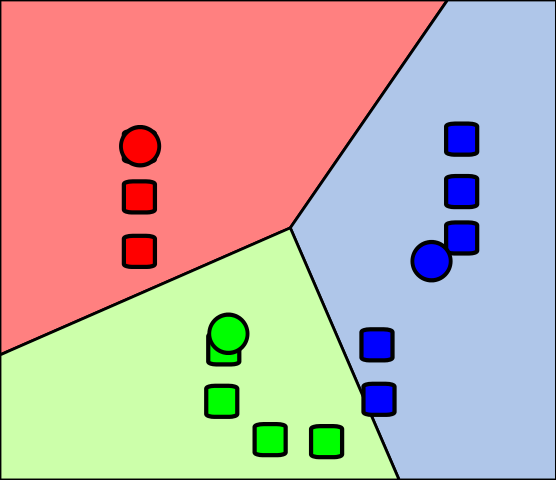

Images by Weston.pace , license CC-BY-SA 3.0







## 1. serial implementation

Here is a simple serial implementation of the algorithm 

In [4]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

def computeDistanceToCentroid( points , centroid ):
	""" computes the squared euclidian distance between a set of <points> and a <centroid>.
		<points> is a 'number of dimensions'*n array
		<centroid> is a 1*'number of dimensions' array

		the distances are returned as a 1*n array

	doctest strings :

	>>> p = np.array([[ 0,  0, 1, 1],[ 0,  1, 0, 1]])
	>>> c = np.array([ 0.5, 0.5])
	>>> computeDistanceToCentroid(p,c)
	array([[0.5, 0.5, 0.5, 0.5]])

	""" 
	distances = np.zeros([1,points.shape[1]])
	for i in range( points.shape[0] ):
		distances += np.power( points[i,] - centroid[i] , 2 )
	return distances

def computeNearestCentroid( points , centroids ):
	""" computes the closest <centroid> for each point in <points>
		<points> is a 'number of dimensions'*n array
		<centroids> is a list of 1*'number of dimensions' array

		The closest are returned as a 1*n array
		that contains the index of the closest centroid


	doctest strings :

	>>> p = np.array([[ 0,  0, 1, 1],[ 0,  1, 0, 1]])
	>>> c = [ np.array([ -0.5, 0.5]) , np.array([ 1.5, 0.5]) ]
	>>> computeNearestCentroid(p,c)
	array([0, 0, 1, 1])

	""" 

	nbPoints = points.shape[1]
	nbCentroids = len(centroids)

	#1. computing distances 
	distances = np.empty([ nbCentroids , nbPoints ])
	for i in range( nbCentroids ):
		distances[i,] = computeDistanceToCentroid( points , centroids[i] )

	#2. finding the closest centroid for each point
	closestCentroid = np.apply_along_axis(np.argmin , 0 , distances )
	
	return closestCentroid

def computeCentroids( points , assignments , k ):
	""" computes the centroids for <points> with a given <assignment>
		<points> is a 'number of dimensions'*n array
		<assignements> is a 1*n array containing indexes from 0 to <k>
		

		Centroids are returned as a list of 'number of dimensions'*1 arrays

	doctest strings :

	>>> p = np.array([[ 0,  0, 1, 1],[ 0,  1, 0, 1]])
	>>> a = np.array([0, 0, 1, 1])
	>>> computeCentroids( p , a , 2 )
	[array([0. , 0.5]), array([1. , 0.5])]
	"""
	nbDim = points.shape[0]
	nbPoint = points.shape[1]

	centroids = [ np.zeros(nbDim) for i in range(k) ]
	clusterSize = [ 0 ] * k

	##summing all values
	for i in range(nbPoint) :
		cluster  = assignments[i]
		centroids[ cluster ] +=  points[:,i]
		clusterSize[ cluster ] += 1
	
	##dividng by cluster size
	for i in range(k):
		centroids[ i ] /= clusterSize[ i ]

	return centroids

def KmeanRound( points , centroids ):
	"""
	For each point, compute the nearest centroid.
	Then computes new centroids based on the assignment.
	

	<points> is a 'number of dimensions'*n array
	<centroids> is a list of 1*'number of dimensions' array

	Returns :
		* the new centroids : list of 'number of dimensions'*1 arrays
		* new assignment : as a 1*n array containing indexes from 0 to k

	"""

	assignment = computeNearestCentroid( points , centroids )
	newCentroids = computeCentroids( points , assignment , len(centroids) )
	return newCentroids,assignment

def Kmeans( points , k , maxNbRounds=1000 , assignment = None ):
	"""
	<points> is a 'number of dimensions'*n array
	<k> : number of clusters
	<maxNbRounds> : maximum number of Kmean round to perform

	Returns a cluster assignment : as a 1*n array containing indexes from 0 to k

	"""
	nbPoints = points.shape[1]

	#1. initialization 
	if assignment is None:
		#we use the random assignment here.
		assignment = np.random.randint(0,k,nbPoints)

	centroids = computeCentroids( points , assignment , k )
	round = 1

	while( round < maxNbRounds ):
		centroids,newAssignment = KmeanRound( points , centroids )

		nbChanged = np.sum( newAssignment != assignment )
		
		assignment = newAssignment
		
		if nbChanged == 0: # nothing has changed -> we have converged !
			break
		elif nbChanged == nbPoints:
			## something fishy occurs -> redraw random points to allow convergence
			assignment = np.random.randint(0,k,nbPoints)
			centroids = computeCentroids( points , assignment , k )

		#print("round {}, {:.2%} points changed assignment".format(round,nbChanged/nbPoints))
		round+=1
		#plotClusters( points , assignment , assignment , dimX=0 , dimY=1 )
		#plt.show()


	return assignment


Let's define a couple of helper functions to generate some clusters and to plot our results :

In [5]:
import matplotlib.pyplot as plt


def generateCluster( n , means , sds ):
	''' 
	draw <n> points 
	from a multidimensional normal distribution 
	of means <means> (list)
	and standard deviation <sds> (list)

	the point are returned as a 'number of dimensions'*<n> array
	'''

	P = np.random.randn( len(means) , n )
	for i in range(len(means)):
		P[i,] = P[i,] * sds[i] + means[i]
	return P


def plotClusters( points , color_assignment , symbol_assignment , dimX=0 , dimY=1 ):
	"""
	plots a scatter plot with the defined color and symbol assignment.
	<points> is a 'number of dimensions'*<n> array
	<dimX> : index of the dimension that will be used as X (default 0)
	<dimY> : index of the dimension that will be used as Y (default 1)

	OK up until 22 symbol assignments
	"""
	fig, ax = plt.subplots(figsize=(15, 15)) 
	symbols = ["o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|",]
	colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
	for i, c in enumerate(np.unique(symbol_assignment)):
		mask = symbol_assignment == c
		plt.scatter(points[dimX,:][mask],
					points[dimY,:][mask],
					c=[ colors[x] for x in color_assignment[mask]], marker=symbols[c])



Now let's test our CPU implementation: we generate 5 groups of points centered around different means and with different standard deviations in a 2-dimensional space.

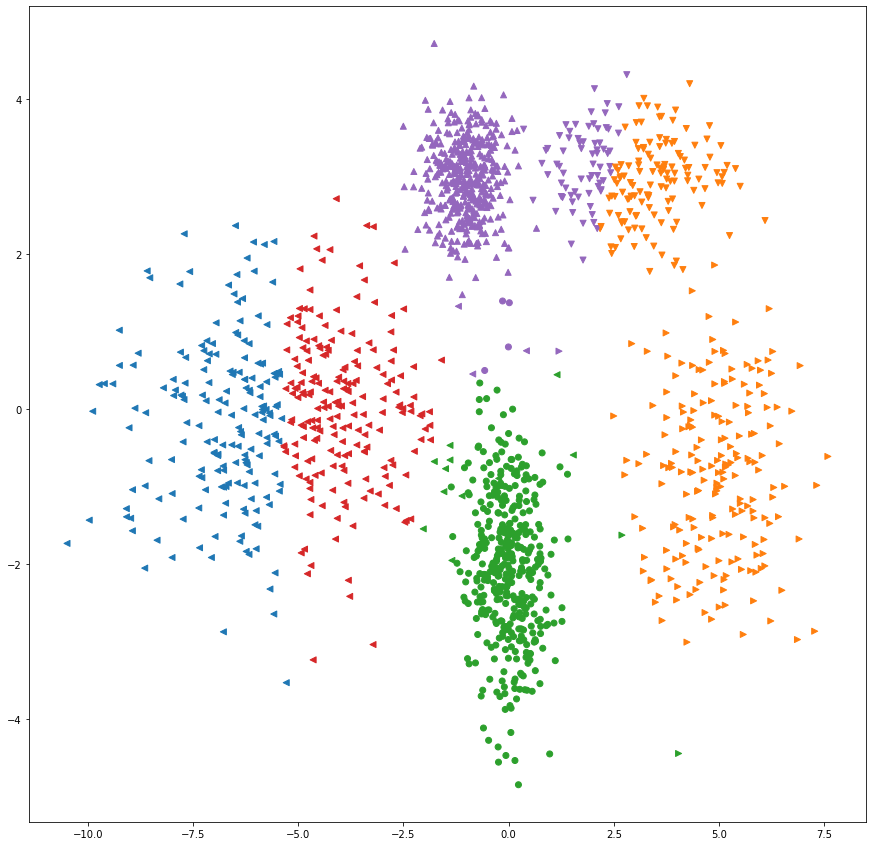

In [6]:
# doctest  is used to perform unit test we wrote in the function's documentations
import doctest
test = doctest.testmod() 
if test.failed>0:
	print('doctest failed some tests')
	print(test)
	exit(0)

import time

# generating data

## 5 clusters of points 
clusterSizes = [400,200,400,400,200 ]
clusterMeans = [ [ 0 , -2 ] ,
				 [ 3 , 3 ] ,
				 [ -1 , 3 ], 
				 [-5, 0] , 
				 [5,-1] ]
clusterSDs = [ [0.5,1] ,
			   [1,0.5] ,
			   [0.5,0.5],
			   [2,1] ,
			   [1,1] ]
C = []
A = []
for i in range( len(clusterSizes) ):
	C.append( generateCluster( clusterSizes[i] , clusterMeans[i] , clusterSDs[i] ) )	
	A += [i]*clusterSizes[i]

Points = np.concatenate( C , axis=1)

realAssignment = np.array(A)


# performing Kmean
k=5

kmeanAssignment = Kmeans( Points , k , maxNbRounds=1000 )

## plotting : color are the Kmean assignment, symbols are the real assignment
# OK up until 22 real clusters
plotClusters( Points , kmeanAssignment , realAssignment , dimX=0 , dimY=1 )
plt.show()


#	### sk learn version - for culture
#	from sklearn.cluster import KMeans as scKmeans
#	X = Points.T ## scikit learn expects another shpae for the points
#	t0 = time.time()
#	kmeans = scKmeans(n_clusters=k, random_state=0).fit(X)
#	t1 = time.time()
#	print('scikit-learn :',t1-t0,'seconds')



The symbols correspond to the real group, and the colors correspond to the cluster assigned by the k-mean algorithm.

> Note that the algorithm does not always retrieve the correct clusters (it only does so about 50% of the time here). Also, there is always some points which are misassigned.



The code seems to do what we want it to. 

## profiling the code

The `%prun` magic command is used to perform time profiling with `cProfile` on a single command line.
It will create a (long) summary giving us information about the time spent in various functions in our code. For our purpose, the column that insterests us the most is `cumtime` where we look for a function that took a substantial percentage of the execution time.



In [7]:
# generating some random data 
clusterSizes = [4000,2000,4000,4000,2000 ]
clusterMeans = [ [ 0 , -2 ] , [ 3 , 3 ] ,[ -1 , 3 ], [-5, 0] , [5,-1] ]
clusterSDs = [ [0.5,1] ,[1,0.5] ,[0.5,0.5],[2,1] ,[1,1] ]
C = []
A = []
for i in range( len(clusterSizes) ):
	C.append( generateCluster( clusterSizes[i] , clusterMeans[i] , clusterSDs[i] ) )	
	A += [i]*clusterSizes[i]
Points = np.concatenate( C , axis=1)
realAssignment = np.array(A)

# performing Kmean
k=5
%prun -l 20 -s cumtime  kmeanAssignment = Kmeans( Points , k , maxNbRounds=1000 ) 
# the %prun magic command activate profiling
#  -l 20 : limits the report to 20 lines
#  -s cumtime : sort by decreasing cumtime


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


We are mostly interested in the `cumtime` column, which gives the total time spent in the function itself + all functions it calls. 

What I see is that on 2.922 seconds of computations, I spend a total of 2.348 seconds in function `computeNearestCentroid`, and more specifically 2.311 seconds in the `apply_along_axis` line. 

This corresponds to about 80% of execution time spent on that line alone, so I will concentrate my optimization efforts on this line. If I am successful, I could speed up execution time by a factor up to 5.

> Note : you mileage may vary : while playing with this code, it took between 1.6sec and 5sec to run. However the `apply_along_axis` always took about 80% of the execution time


## 2. Speeding up a single function using numba.cuda 

### problem setup

We reproduce the function that takes up most of the execution time 
(around 80%) in the Kmeans computation.

In itself, the goal of this function is to return the closest centroid for each points, given the set of distances between each point and each centroid.

Here are a number of fairly naive implementations to test out :
 * getClosestCentroid : original numpy-based implementation
 * getClosestCentroidJIT : using numba JIT compilation (CPU based)
 * getClosestCentroidNaiveCuda : a naive numba.cuda implementation
 * getClosestCentroidNaiveCudaNoIf : numba.cuda implementation, trying to avoid if conditions

In [8]:
from numba import cuda
from numba import jit
import numpy as np

def getClosestCentroid( distances ):
    '''
        distances : (m,n) array where 
            m : number of centroids
            n : number of data points
        closestCentroid : 1,n array
    '''
    return np.apply_along_axis(np.argmin , 0 , distances )

@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def getClosestCentroidJIT( distances , closest ):
    '''
        distances : (n,m) array where 
            m : number of centroids
            n : number of data points
        closestCentroid : 1,n array
    '''
    n,m = distances.shape
    i=0
    while i < n:
      closest[i] = np.argmin( distances[i] )
      i+=1

    return closest

@cuda.jit
def getClosestCentroidNaiveCuda( distances , m , closestCentroid):
    '''
        distances : (n,m) array where 
            m : number of centroids
            n : number of data points
        closestCentroid : 1,n array
    '''
    # here is the naive re-implementation of the function using numba.cuda 
    # here the kernel operates on a single data point
    pos = cuda.grid(1) # getting the point index
    if pos < closestCentroid.size:
        # We go through all distances between that point and the centroids to find the closest one
        # This is purposefully done in the most naive way
        x=1
        minVal=distances[pos,0]
        minInd=0
        while x < m:
            if distances[pos,x]<minVal:
                minVal=distances[pos,x]
                minInd=x
            x +=1            
        closestCentroid[pos] = minInd
    
@cuda.jit
def getClosestCentroidNaiveCudaNoIf( distances , m , closestCentroid):
    '''
        distances : (n,m) array where 
            m : number of centroids
            n : number of data points
        closestCentroid : 1,n array
    '''
    # In this re-implemntation we try to avoid the if in the loop
    # the kernel operates on a single data point
    pos = cuda.grid(1) # getting the point index
    if pos < closestCentroid.size:
        # We go through all distances between that point and the centroids to find the closest one

        minVal=distances[pos,0]
        minInd=0
        for x in range(1,m):
            diff = int( ( distances[pos,x] - minVal)>0 ) # 0 if distances[pos,x] is smaller , 1 otherwise
            Ndiff = 1-diff
            minVal = minVal*diff + distances[pos,x]*Ndiff
            minInd = minInd*diff + x*Ndiff

        closestCentroid[pos] = minInd


### verifying our results

The first step is to verify that our different implementations give the same results.


We will test them out on some randomly generated distances :

---



In [9]:
m=3
n=64

distances = np.random.random((m,n))
distancesT = distances.T  # the new implementations work in distanceT

In [10]:
# Let's use block size of 1 thread for now
threadsperblock = 1
blockspergrid = (distancesT.size + (threadsperblock - 1)) // threadsperblock


closestCentroid1 = np.empty((n,))
closestCentroid2 = np.empty((n,))
closestCentroid3 = np.empty((n,))
closestCentroid4 = np.empty((n,))

closestCentroid1 = getClosestCentroid( distances )
getClosestCentroidJIT( distancesT , closestCentroid2 )
getClosestCentroidNaiveCuda[blockspergrid, threadsperblock]( distancesT , m , closestCentroid3 )
getClosestCentroidNaiveCudaNoIf[blockspergrid, threadsperblock]( distancesT , m , closestCentroid4 )

print('same results with numba JIT :',np.allclose(closestCentroid1,closestCentroid2))
print('same results with numba.cuda:',np.allclose(closestCentroid1,closestCentroid3))
print('same results with numba.cuda no ifs:',np.allclose(closestCentroid1,closestCentroid4))

same results with numba JIT : True
same results with numba.cuda: True
same results with numba.cuda no ifs: True


### optimizing the number of threads per blocks

The number of threads per block can have an important impoact on performance. 
As a (crude) procedure to set that parameter,
we will perform a test on some random data and choose the value associated with the best timing.

The `%timeit` magic command helps us measure the execution time to a specific command.


In [11]:
m=8
n=128000
distances = np.random.random((m,n))
distancesT = distances.T

closestCentroid = np.empty((n,))

for threadsperblock in [1,2,4,8,16,32,64]:
  blockspergrid = (distancesT.size + (threadsperblock - 1)) // threadsperblock
  resGPU = %timeit -q -n 2 -r 10 -o getClosestCentroidNaiveCuda[blockspergrid, threadsperblock]( distancesT , m , closestCentroid )
  print(threadsperblock,'thread per block:','2 loops, best of 10: {:.1f} ms per loop'.format(resGPU.best*1000))

1 thread per block: 2 loops, best of 10: 8.2 ms per loop
2 thread per block: 2 loops, best of 10: 6.4 ms per loop
4 thread per block: 2 loops, best of 10: 5.7 ms per loop
8 thread per block: 2 loops, best of 10: 5.3 ms per loop
16 thread per block: 2 loops, best of 10: 5.4 ms per loop
32 thread per block: 2 loops, best of 10: 5.3 ms per loop
64 thread per block: 2 loops, best of 10: 5.3 ms per loop


We can see there is a substantial amount of difference between the worst and best value (last time we checked : 7.1ms to 3.9ms, so a x1.8 speedup).

From these results, we decide to use the set the number of threads per block to 32.

### comparing the different implementations

We now compare the execution time of the different implementation on our test data-set:

In [12]:
m=8
n=128000
distances = np.random.random((m,n))
distancesT = distances.T

# we set the number of thread per block to 32
threadsperblock = 32
blockspergrid = (distancesT.size + (threadsperblock - 1)) // threadsperblock


closestCentroid1 = np.empty((n,))
closestCentroid2 = np.empty((n,))
closestCentroid3 = np.empty((n,))
closestCentroid4 = np.empty((n,))

# the %timeit magic command used here will perform 10 runs of 2 loops each and report execution times.
resCPU = %timeit -q -n 2 -r 10 -o closestCentroid1 = getClosestCentroid( distances )

resCPU2 = %timeit -q -n 2 -r 10 -o getClosestCentroidJIT( distancesT , closestCentroid2 )

resGPU = %timeit -q -n 2 -r 10 -o getClosestCentroidNaiveCuda[blockspergrid, threadsperblock]( distancesT , m , closestCentroid3 )
resGPU2 = %timeit -q -n 2 -r 10 -o getClosestCentroidNaiveCudaNoIf[blockspergrid, threadsperblock]( distancesT , m , closestCentroid4 )

print( "base implementation time : {:.1f}ms".format(resCPU.best*1000) )
print("numba.jit CPU speedup : x{:.1f}".rjust(35).format(resCPU.best/resCPU2.best) )
print("GPU speedup : x{:.1f}".rjust(35).format(resCPU.best/resGPU.best))
print("GPU no-if speedup : x{:.1f}".rjust(35).format(resCPU.best/resGPU2.best))

base implementation time : 485.0ms
    numba.jit CPU speedup : x115.7
              GPU speedup : x93.0
        GPU no-if speedup : x92.2


Quite interestingly, in that case the speedup is strongest on the CPU-optimized code generated by `numba.jit`.

Getting a speedup value is nice, but surely this depends heavily on the dimension of the problem, which is basically the number of points (n) and number of clusters (m).

Let's explore the speedup we can achieve for different values. 

### comparing for different problem sizes

We begin by comparing the base CPU implementation to the naive GPU one for moderate problem sizes.
 * number of points from 1 024 to 65 536
 * number of clusters from 2 to 128

In [13]:
nbSteps = 7
startlog2N = 10
speedup_CPU_GPU = np.zeros((nbSteps,nbSteps))

x = 0
for log2n in np.linspace(startlog2N,startlog2N+nbSteps-1,nbSteps): # n between 2**7 and 2**14
    y=0
    print('number of points {}'.format(int(2**log2n)))
    for log2m in np.linspace(1,7,nbSteps): # m between 2 and 128
        n = int(2**log2n)
        m = int(2**log2m)
        distances = np.random.random((m,n))
        distancesT = distances.T
        closestCentroid1 = np.empty((n,))
        closestCentroid2 = np.empty((n,))

        resCPU = %timeit -q -n 1 -r 1 -o closestCentroid1 = getClosestCentroid( distances )
        resGPU = %timeit -q -n 1 -r 2 -o getClosestCentroidNaiveCuda[blockspergrid, threadsperblock]( distancesT , m , closestCentroid2 )

        speedup_CPU_GPU[x,y] = resCPU.best/resGPU.best
        y+=1
    x+=1
    

number of points 1024
number of points 2048
number of points 4096
number of points 8192
number of points 16384
number of points 32768
number of points 65536


Let's plot the results :

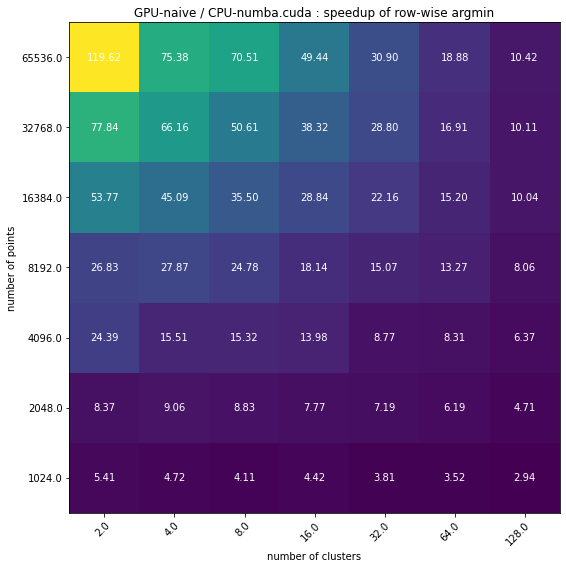

In [14]:
import matplotlib
import matplotlib.pyplot as plt


def plotSpeedupMatrix( speedup , Ns , Ms , title ): 

  fig, ax = plt.subplots(figsize=(8,8))
  im = ax.imshow(speedup)

  # We want to show all ticks...
  ax.set_xticks(np.arange(len(Ms)))
  ax.set_yticks(np.arange(len(Ns)))
  # ... and label them with the respective list entries
  ax.set_xticklabels(Ms)
  ax.set_yticklabels(Ns)

  ax.set_xlabel('number of clusters')
  ax.set_ylabel('number of points')

  ax.set_xlim(-0.5,len(Ms)-0.5)
  ax.set_ylim(-0.5,len(Ns)-0.5)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  for i in range(len(Ns)):
    for j in range(len(Ms)):
      col = 'w'
      if speedup[i, j] < 1.0:
        col = 'r'
      text = ax.text(j, i, '{:.2f}'.format(speedup[i, j]),
                     ha="center", va="center", color=col)
  
  ax.set_title(title)
  fig.tight_layout()
  plt.show()

Ns = 2**np.linspace(startlog2N,startlog2N+nbSteps-1,nbSteps)
Ms = 2**np.linspace(1,7,7)
title = "GPU-naive / CPU-numba.cuda : speedup of row-wise argmin"
plotSpeedupMatrix( speedup_CPU_GPU , Ns , Ms , title )

As expected, the speedup gets better with larger problems


Let us compare the GPU implementation to the numba.jit one on larger problem sizes.

 * number of points from 65 536 to 4 194 304
 * number of clusters from 2 to 128

> NOTE : the next cell can take a couple of minutes to execute

In [17]:
nbSteps = 7
startlog2N = 16
speedup_CPU_GPU = np.zeros((nbSteps,nbSteps))
speedup_GPUnoIf_GPU = np.zeros((nbSteps,nbSteps))

threadsperblock = 32
blockspergrid = (distancesT.size + (threadsperblock - 1)) // threadsperblock

x = 0
for log2n in np.linspace(startlog2N,startlog2N+nbSteps-1,nbSteps): # n between 2**16 and 2**22
    y=0
    n = int(2**log2n)
    print('number of points {}, number of clusters :'.format(n) , end='')
    for log2m in np.linspace(1,1+nbSteps-1,nbSteps): # m between 2 and 128
        
        m = int(2**log2m)
        print('{}'.format(m) , end=' ')
        distances = np.random.random((m,n))
        distancesT = distances.T
        closestCentroid1 = np.empty((n,))
        closestCentroid2 = np.empty((n,))
        closestCentroid3 = np.empty((n,))

        resCPU = %timeit -q -n 1 -r 2 -o getClosestCentroidJIT( distancesT , closestCentroid1 )
        resGPU = %timeit -q -n 1 -r 2 -o getClosestCentroidNaiveCuda[blockspergrid, threadsperblock]( distancesT , m , closestCentroid2 )
        resGPU2 = %timeit -q -n 1 -r 2 -o getClosestCentroidNaiveCudaNoIf[blockspergrid, threadsperblock]( distancesT , m , closestCentroid3 )

        speedup_CPU_GPU[x,y] = resCPU.best/resGPU.best
        speedup_GPUnoIf_GPU[x,y] = resGPU.best/resGPU2.best
        y+=1
    print('')
    x+=1

    

number of points 65536, number of clusters :2 4 8 16 32 64 128 
number of points 131072, number of clusters :2 4 8 16 32 64 128 
number of points 262144, number of clusters :2 4 8 16 32 64 128 
number of points 524288, number of clusters :2 4 8 16 32 64 128 
number of points 1048576, number of clusters :2 4 8 16 32 64 128 
number of points 2097152, number of clusters :2 4 8 16 32 64 128 
number of points 4194304, number of clusters :2 4 8 16 32 64 128 


Let's plot the speedup between GPU and numba.jit :

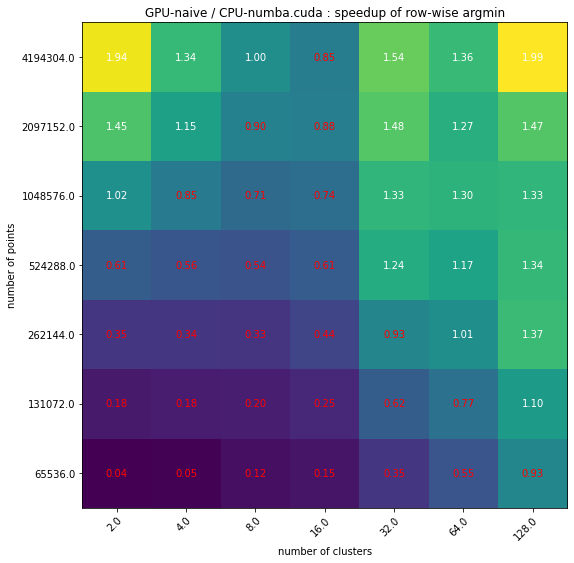

In [18]:
plotSpeedupMatrix( speedup_CPU_GPU , 
                    Ns = 2**np.linspace(startlog2N,startlog2N+nbSteps-1,nbSteps),
                    Ms = 2**np.linspace(1,7,7),
                    title = "GPU-naive / CPU-numba.cuda : speedup of row-wise argmin")


Indeed, it appears that the GPU implementation outperforms the numba.cuda CPU code only when the problem is large enough. 

Let us know compare the 2 GPU code to see if removing the ifs add a large impact for our problem :

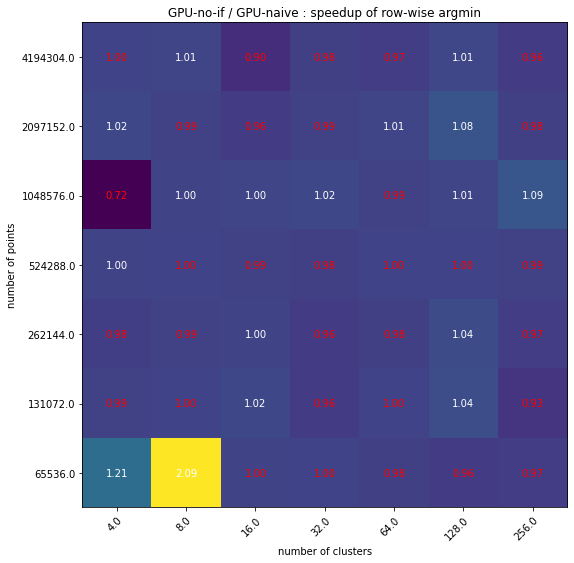

In [20]:
plotSpeedupMatrix( speedup_GPUnoIf_GPU , 
                    Ns = 2**np.linspace(startlog2N,startlog2N+nbSteps-1,nbSteps),
                    Ms = 2**np.linspace(2,8,7),
                    title = "GPU-no-if / GPU-naive : speedup of row-wise argmin")


It would appear there is no clear differences between the two GPU implementations.



## 3. Testing it in practice

We have seen how to re-implement a single function using numba.cuda.

We now re-implement the wrapping functions to incorporate my numba.cuda optimized function in the Kmean algorithm.

In [21]:

# this is our numba.cuda function
@cuda.jit
def getClosestCentroidNaiveCuda( distances , m , closestCentroid):
    '''
        distances : (m,n) array where 
            m : number of centroids
            n : number of data points
        closestCentroid : 1,n array
    '''
    pos = cuda.grid(1)
    if pos < closestCentroid.size:
        x=1
        minVal=distances[0,pos]
        minInd=0
        while x < m:
            if distances[x,pos]<minVal:
                minVal=distances[x,pos]
                minInd=x
            x +=1            
        closestCentroid[pos] = minInd
    
#the only changed thing is that it call our cuda function instead of np.apply_along_axis
def computeNearestCentroid_callingCUDA( points , centroids ):
    """ computes the closest <centroid> for each point in <points>
        <points> is a 'number of dimensions'*n array
        <centroids> is a list of 1*'number of dimensions' array

        The closest are returned as a 1*n array
        that contains the index of the closest centroid


    doctest strings :

    >>> p = np.array([[ 0,  0, 1, 1],[ 0,  1, 0, 1]])
    >>> c = [ np.array([ -0.5, 0.5]) , np.array([ 1.5, 0.5]) ]
    >>> computeNearestCentroid(p,c)
    array([0, 0, 1, 1])

    """ 

    nbPoints = points.shape[1]
    nbCentroids = len(centroids)

    #1. computing distances 
    distances = np.empty([ nbCentroids , nbPoints ])
    for i in range( nbCentroids ):
        distances[i,] = computeDistanceToCentroid( points , centroids[i] )

    #2. finding the closest centroid for each point
 
    closestCentroid = np.empty((nbPoints,) , dtype=int)
 

    threadsperblock=1
    blockspergrid = (nbPoints + (threadsperblock - 1)) // threadsperblock

    getClosestCentroidNaiveCuda[blockspergrid, threadsperblock]( distances , nbCentroids , closestCentroid )
 
    #closestCentroid = np.apply_along_axis(np.argmin , 0 , distances )
    
    return closestCentroid

#the only changed thing is that it calls computeNearestCentroid_callingCUDA instead of computeNearestCentroid
def KmeanRound_callingCUDA( points , centroids ):
    """
    For each point, compute the nearest centroid.
    Then computes new centroids based on the assignment.
    

    <points> is a 'number of dimensions'*n array
    <centroids> is a list of 1*'number of dimensions' array

    Returns :
        * the new centroids : list of 'number of dimensions'*1 arrays
        * new assignment : as a 1*n array containing indexes from 0 to k

    """

    assignment = computeNearestCentroid_callingCUDA( points , centroids )
    newCentroids = computeCentroids( points , assignment , len(centroids) )
    return newCentroids,assignment

#the only changed thing is that it calls KmeanRound_callingCUDA instead of KmeanRound
def Kmeans_CUDA( points , k , maxNbRounds=1000 , assignment = None):
    """
    <points> is a 'number of dimensions'*n array
    <k> : number of clusters
    <maxNbRounds> : maximum number of Kmean round to perform

    Returns a cluster assignment : as a 1*n array containing indexes from 0 to k

    """
    nbPoints = points.shape[1]

    #1. initialization 
    if assignment is None:
        #I use the random assignment here.
        assignment = np.random.randint(0,k,nbPoints)

    centroids = computeCentroids( points , assignment , k )
    round = 1

    while( round < maxNbRounds ):
        centroids,newAssignment = KmeanRound_callingCUDA( points , centroids )

        nbChanged = np.sum( newAssignment != assignment )
        
        assignment = newAssignment
        
        if nbChanged == 0: # nothing has changed -> we have converged !
            break
        elif nbChanged == nbPoints:
            ## something fishy occurs -> redraw random points to allow convergence
            assignment = np.random.randint(0,k,nbPoints)
            centroids = computeCentroids( points , assignment , k )

        #print("round {}, {:.2%} points changed assignment".format(round,nbChanged/nbPoints))
        round+=1
        #plotClusters( points , assignment , assignment , dimX=0 , dimY=1 )
        #plt.show()


    return assignment


We generate some data :



In [31]:
1/(0.2+0.8*(1/15.))

3.9473684210526314

In [30]:
from numba import cuda
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

import time

# generating data

## 4 clusters of points 
clusterSizes = [1500,1100,620,876 ]
clusterMeans = [ [ 0 , -2 ] , [ 3 , 3 ] , [ -1 , 3 ], [-5, 0] ]
clusterSDs = [ [0.5,1] , [1,0.5] , [0.5,0.5], [2,1] ]

C = []
A = []
for i in range( len(clusterSizes) ):
	C.append( generateCluster( clusterSizes[i] , clusterMeans[i] , clusterSDs[i] ) )	
	A += [i]*clusterSizes[i]

Points = np.concatenate( C , axis=1)

#shuffling points 
Points = np.transpose(Points)
np.random.shuffle(Points)
Points = np.transpose(Points)

realAssignment = np.array(A)


Here there is 4 clusters, and 4096 points. According to our heatmap, the optimized function should have a speedup factor of about 15 (your mileage may vary).
Because this function took about 80% of the Kmean execution time, that should result in a speedup of around ~3.95 (1/(0.2 + 0.8/speedup))). 

In [39]:

# performing Kmean numba cuda
k=4

InitAssignment = np.random.randint(0,k,sum(clusterSizes))

GPU = %timeit -q -o kmeanAssignment = Kmeans_CUDA( Points , k , maxNbRounds=1000 , assignment=InitAssignment )
CPU = %timeit -q -o kmeanAssignment = Kmeans( Points , k , maxNbRounds=1000 , assignment=InitAssignment )

print( "n=",sum(clusterSizes) , '\tk=',k )
print( "numba.cuda finished in {:.2f} ms.".format(GPU.best*1000).rjust(35) )
print( "serial finished in {:.2f} ms.".format(CPU.best*1000).rjust(35) )
print('speedup : {:.3f}'.format(CPU.best/GPU.best) )


n= 4096 	k= 4
   numba.cuda finished in 54.77 ms.
      serial finished in 154.58 ms.
speedup : 2.822


These speedup factor is a bit less than what we expected.

The next step in the optimization procedure would be to either :
 * continue optimizing `computeNearestCentroid`
 * optimize another function

In our specific case, if your expected problem size is such that you expect`computeNearestCentroid` to be sped up by at least a factor 4, then `computeCentroids` would become the most time consuming function in our code and we could want to spend some time optimizing it.

